In [1]:
import pandas as pd
import numpy as np
print("✅ Kernel & Library Berjalan Normal!")


✅ Kernel & Library Berjalan Normal!


In [2]:
pip install numpy pandas matplotlib pmdarima statsmodels scikit-learn openpyxl


  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 14.3 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   -------------------------- ------------- 4/6 [conto

In [1]:
import pandas as pd

# 1️⃣ Baca data
df = pd.read_excel("data_pengunjung_perpustakaan.xlsx", parse_dates=['Tanggal'])

# 2️⃣ Hapus duplikat timestamp
df = df.drop_duplicates(subset=['Tanggal'])

# 3️⃣ Pastikan kolom Jumlah_Pengunjung bertipe angka
df['Jumlah_Pengunjung'] = pd.to_numeric(df['Jumlah_Pengunjung'], errors='coerce')

# 4️⃣ Buat kolom tanggal saja (tanpa jam)
df['Tanggal_Harian'] = df['Tanggal'].dt.date

# 5️⃣ Group by per hari → jika ada lebih dari 1 record per hari, dijumlahkan
df_daily = df.groupby('Tanggal_Harian')['Jumlah_Pengunjung'].sum()

# 6️⃣ Ubah index ke datetime
df_daily.index = pd.to_datetime(df_daily.index)

# 7️⃣ Resample menjadi harian, hari tanpa data → 0
df_daily = df_daily.resample('D').sum().fillna(0)

print("Hasil data harian yang sudah bersih:")
display(df_daily.head(10))
display(df_daily.tail(10))


Hasil data harian yang sudah bersih:


Tanggal_Harian
2025-07-29    107
2025-07-30    233
2025-07-31    144
2025-08-01    121
2025-08-02     42
2025-08-03      0
2025-08-04    155
2025-08-05    133
2025-08-06     79
2025-08-07     88
Freq: D, Name: Jumlah_Pengunjung, dtype: int64

Tanggal_Harian
2025-11-12    465
2025-11-13    630
2025-11-14    512
2025-11-15    102
2025-11-16      0
2025-11-17    498
2025-11-18    521
2025-11-19    509
2025-11-20    547
2025-11-21    566
Freq: D, Name: Jumlah_Pengunjung, dtype: int64

Data terakhir pada file: 2025-11-21
Train length = 92, Test length = 24
Loading saved SARIMA model.

Evaluation on test set:
RMSE = 85.514
MAPE = 35.39%


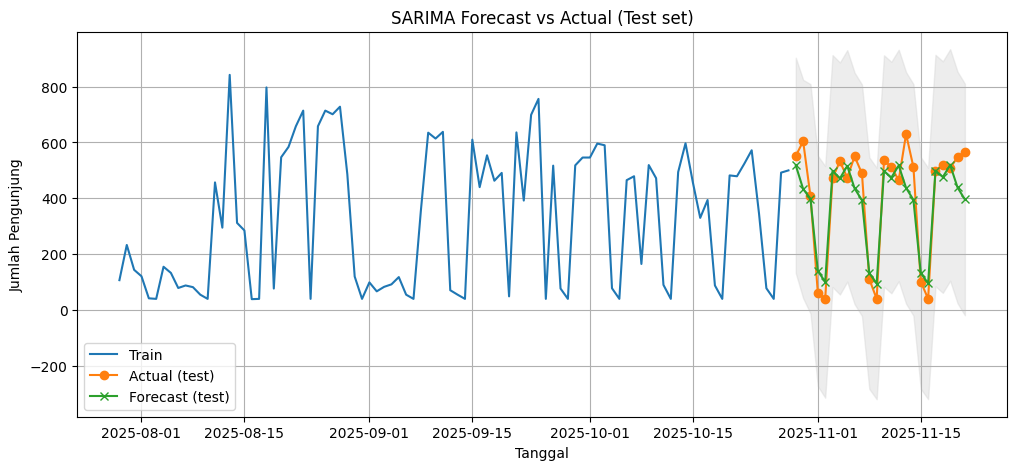


Last observed date = 2025-11-21
Forecast requested start = 2025-11-24 (days gap = 3)
Requesting SARIMA to forecast 9 steps ahead and then selecting last 6 values.

🔮 Forecast mulai 24 Nov 2025 (6 hari):
            Forecast  Lower_CI  Upper_CI
2025-11-24       140      -272       552
2025-11-25       101      -314       516
2025-11-26       498        83       913
2025-11-27       471        56       886
2025-11-28       516       102       930
2025-11-29       435        21       850


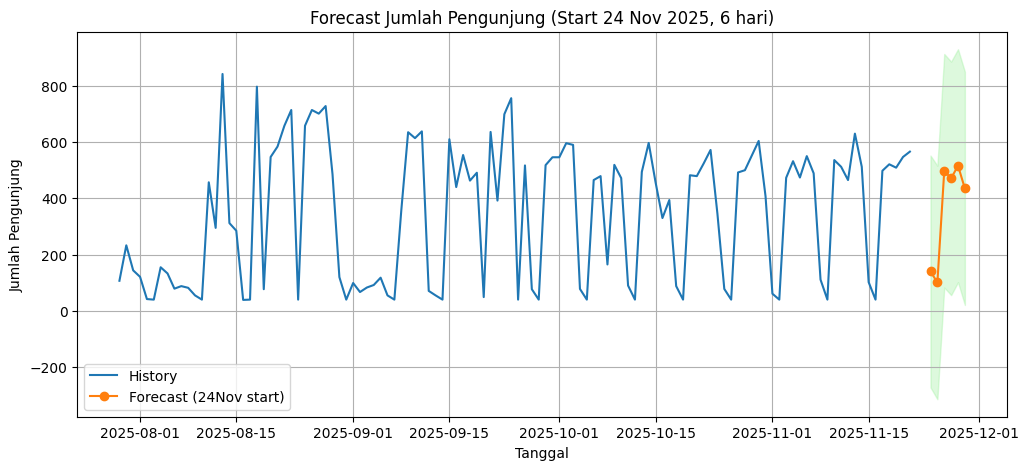


Selesai.


In [4]:
# ===================================================================================
# SARIMA FINAL — Train sampai 2025-11-21, Forecast mulai 2025-11-24 selama 6 hari
# ===================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import joblib
import math
import os
import warnings
warnings.filterwarnings("ignore")

# -----------------------
# CONFIG
# -----------------------
excel_filename = "data_pengunjung_perpustakaan.xlsx"
model_path = "sarima_model.pkl"
forecast_start = pd.Timestamp("2025-11-24")   # mulai forecast yang Anda minta
forecast_horizon = 6                          # jumlah hari yg diinginkan (6 hari: 24-29 Nov)

# -----------------------
# 1) LOAD & PREP DATA
# -----------------------
df = pd.read_excel(excel_filename)
if "Tanggal" not in df.columns:
    raise ValueError("Kolom 'Tanggal' tidak ditemukan di file Excel!")

df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')
df = df.dropna(subset=['Tanggal']).copy()
df = df.sort_values('Tanggal').reset_index(drop=True)

# set index
df = df.set_index('Tanggal')

# resample harian dan isi hari kosong dengan 40
data_daily = df.resample('D').sum()
data_daily['Jumlah_Pengunjung'] = (
    data_daily['Jumlah_Pengunjung']
    .replace(0, 40)
    .fillna(40)
).astype(int)

# quick check last date
last_date = data_daily.index[-1]
print(f"Data terakhir pada file: {last_date.date()}")

# -----------------------
# 2) TRAIN / TEST SPLIT (80% train)
# -----------------------
train_size = int(len(data_daily) * 0.8)
train_df = data_daily.iloc[:train_size].copy()
test_df  = data_daily.iloc[train_size:].copy()

# use series (1-d) for modeling functions
train_series = train_df['Jumlah_Pengunjung']
test_series  = test_df['Jumlah_Pengunjung']

print(f"Train length = {len(train_series)}, Test length = {len(test_series)}")

# -----------------------
# 3) TRAIN / LOAD SARIMA (auto_arima -> SARIMAX)
# -----------------------
def train_and_save(train_series):
    print("\n▶ Running auto_arima to find good SARIMA orders (this may take a while)...")
    auto_m = auto_arima(
        train_series,
        seasonal=True,
        m=7,
        stepwise=True,
        trace=True,
        suppress_warnings=True,
        error_action='ignore'
    )

    print("\nAuto-ARIMA summary:")
    print(auto_m.summary())

    order = auto_m.order
    seasonal_order = auto_m.seasonal_order
    print(f"Selected order: {order}, seasonal_order: {seasonal_order}")

    print("\n▶ Training SARIMAX with selected orders...")
    model = SARIMAX(
        train_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    # save
    joblib.dump({
        "model": res,
        "order": order,
        "seasonal_order": seasonal_order,
        "last_train_date": train_series.index[-1]
    }, model_path)
    print(f"Model saved to {model_path}")
    return res

def load_or_train(train_df):
    if os.path.exists(model_path):
        saved = joblib.load(model_path)
        saved_date = saved["last_train_date"]
        # if new data available, retrain
        if train_df.index[-1] > saved_date:
            print("Newer training data found -> retraining SARIMA.")
            return train_and_save(train_df['Jumlah_Pengunjung'])
        else:
            print("Loading saved SARIMA model.")
            return saved["model"]
    else:
        return train_and_save(train_df['Jumlah_Pengunjung'])

sarima_result = load_or_train(train_df)

# -----------------------
# 4) FORECAST FOR TEST INTERVAL (for evaluation)
# -----------------------
steps_test = len(test_series)
fc_test = sarima_result.get_forecast(steps=steps_test)
fc_test_mean = fc_test.predicted_mean
# evaluation: RMSE & MAPE
rmse = math.sqrt(mean_squared_error(test_series, fc_test_mean))
mape = np.mean(np.abs((test_series - fc_test_mean) / test_series)) * 100

print(f"\nEvaluation on test set:")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# plot train/test vs forecast (test)
plt.figure(figsize=(12,5))
plt.plot(train_df.index, train_df['Jumlah_Pengunjung'], label='Train')
plt.plot(test_df.index, test_df['Jumlah_Pengunjung'], label='Actual (test)', marker='o')
plt.plot(test_df.index, fc_test_mean, label='Forecast (test)', marker='x')
ci = fc_test.conf_int()
plt.fill_between(test_df.index, ci.iloc[:,0], ci.iloc[:,1], color='lightgray', alpha=0.4)
plt.title('SARIMA Forecast vs Actual (Test set)')
plt.xlabel('Tanggal'); plt.ylabel('Jumlah Pengunjung')
plt.legend(); plt.grid(True); plt.show()

# -----------------------
# 5) CUSTOM START FORECAST: mulai 2025-11-24 selama 6 hari
# -----------------------
# check relation between last_date and requested start
if forecast_start <= last_date:
    raise ValueError(f"Requested forecast start ({forecast_start.date()}) is not after last data date ({last_date.date()}).\n"
                     "SARIMA forecasting from a past date not supported here. Please request start > last data date.")

# compute steps to request: number of days from last_date to start_date plus desired horizon
days_to_start = (forecast_start - last_date).days
steps_needed = days_to_start + forecast_horizon

print(f"\nLast observed date = {last_date.date()}")
print(f"Forecast requested start = {forecast_start.date()} (days gap = {days_to_start})")
print(f"Requesting SARIMA to forecast {steps_needed} steps ahead and then selecting last {forecast_horizon} values.")

# get forecast up to target
fc_all = sarima_result.get_forecast(steps=steps_needed)
fc_all_mean = fc_all.predicted_mean
fc_all_ci = fc_all.conf_int()

# take the tail part corresponding to forecast_start ... forecast_start + horizon-1
selected_mean = fc_all_mean[-forecast_horizon:].values
selected_ci = fc_all_ci.iloc[-forecast_horizon:, :].values

future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon)

forecast_table = pd.DataFrame({
    "Forecast": np.round(selected_mean).astype(int),
    "Lower_CI": np.round(selected_ci[:,0]).astype(int),
    "Upper_CI": np.round(selected_ci[:,1]).astype(int)
}, index=future_dates)

print("\n🔮 Forecast mulai 24 Nov 2025 (6 hari):")
print(forecast_table)

# plot history + forecast (24-29 Nov)
plt.figure(figsize=(12,5))
plt.plot(data_daily.index, data_daily['Jumlah_Pengunjung'], label='History')
plt.plot(forecast_table.index, forecast_table['Forecast'], marker='o', label='Forecast (24Nov start)')
plt.fill_between(forecast_table.index, forecast_table['Lower_CI'], forecast_table['Upper_CI'],
                 color='lightgreen', alpha=0.3)
plt.title('Forecast Jumlah Pengunjung (Start 24 Nov 2025, 6 hari)')
plt.xlabel('Tanggal'); plt.ylabel('Jumlah Pengunjung')
plt.legend(); plt.grid(True); plt.show()

print("\nSelesai.")
